# Quantify interaction between theta and low-gamma

In [284]:
## plot
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp
from scipy import stats
from scipy.stats import binned_statistic


## time_frequency
import mne
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

# Load study related info

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs             = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Util functions for signal processing

In [542]:
def hilbert_transform(tmp_lfp_notch, fs):

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)

    raw_band = raw.copy()
    raw_band.filter(2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_phase = raw_hilb.copy()
    raw_phase.apply_function(np.angle, hilb_picks)
    raw_phase = raw_phase.get_data()[0].real

    raw_band = raw.copy()
    raw_band.filter(30, 60, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin')
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks)
    raw_amp = raw_hilb.copy()
    raw_amp.apply_function(np.abs, hilb_picks)
    raw_amp = raw_amp.get_data()[0].real

    return raw_phase, raw_amp


def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L


# Compute coupling

In [543]:
amp_phase = {}

### Run each session
for sub in range(len(sessions)):
    
    amp_phase[sub] = {}
    amp_phase[sub]['phase'] = []
    amp_phase[sub]['amp'] = []
    
    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    
    
    ### Loop through this session/patient hippocampal channel
    for cc in hpc_electrodes[sub]:
        
        ### Get this channel LFP 
        tmp_lfp = lfp[cc]         
        
        tmp_lfp_notch = mne.filter.notch_filter( np.float64(tmp_lfp), fs, [50,100,150,200], notch_widths=20 )
        raw_phase, raw_amp = hilbert_transform(tmp_lfp_notch, fs)

        amp_phase[sub]['phase'].append( raw_phase)
        amp_phase[sub]['amp'].append( raw_amp)

Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 60 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 60 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=209001
    Range : 0 ... 209000 =      0.000 ...   408.203 secs
Ready.
S

Setting up band-pass filter from 30 - 60 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 60 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=205501
    Range : 0 ... 205500 =      0.000 ...   401.367 secs
Ready.
Setting up band-pass filter from 2 - 8 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-pass filter from 30 - 60 Hz
Filter length of 845 samples (1.650 sec) selected
Setting up band-stop filter
Filter length of 3379 samples (6.600 sec) selected
Creating RawArray with float64 data, 

# Distribution of PAC
### All trials

In [544]:
trial_begin           = 500
trial_end             = 3500#4000
# trial_begin           = 0
# trial_end             = 1500


## Trial type
tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
tmp_speed = np.tile( np.arange(3), 9 )
tmp_dur = [ 18.1, 13.5, 11]
tmp_dd = [50,100,150]


log_pac = []
for sub in range(len(sessions)):

    idx_trials = trials_markers[sessions[sub]]

    
    for cc in range(len(amp_phase[sub]['amp'])):

        tmp_amp = amp_phase[sub]['amp'][cc]
        tmp_phase = amp_phase[sub]['phase'][cc]

        
        for trial in range(len(idx_trials)):
            
            tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
            tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
            
            bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp)
            kb = calculate_KB(bs)

            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
            csw = np.argmin(np.abs(cs-np.linspace(2,14,4)))
            log_pac.append( [sub, tmp_density[trial], tmp_speed[trial], cs, csw, kb] )
            
            
            

In [545]:
log_pac = pd.DataFrame(log_pac, columns=['sub','density','speed','cuesec','cuesec_w','kb'] )

              sum_sq     df        F    PR(>F)
kb          2.977728    1.0  4.48027  0.034593
Residual  537.022272  808.0      NaN       NaN
              sum_sq     df         F    PR(>F)
kb          1.221065    1.0  1.831217  0.176362
Residual  538.778935  808.0       NaN       NaN


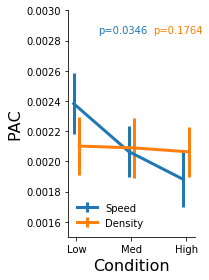

In [546]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)

var_of_interst = 'kb'


mmd = log_pac.groupby(['density']).median()[var_of_interst]
mms = log_pac.groupby(['speed']).median()[var_of_interst]

ssd = log_pac.groupby(['density']).sem()[var_of_interst]
sss = log_pac.groupby(['speed']).sem()[var_of_interst]

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.legend( frameon=False, loc='lower left')

plt.ylabel('PAC', fontsize=16)
plt.xlabel('Condition', fontsize=16)

plt.xticks(range(3), ['Low','Med','High'])

plt.tight_layout()
# plt.savefig('../Figures/theta_dominant_freq_both.pdf')




plt.ylim(0.0015,0.003)

new_blue   = '#1f77b4'
new_orange = '#ff7f03'

ym = plt.ylim()[1]*0.95

cw_lm=ols('speed ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 0.4, ym, pval_str,  fontdict=dict(color=new_blue) )


cw_lm=ols('density ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 0.4+1, ym, pval_str,  fontdict=dict(color=new_orange) )

plt.tight_layout()
# plt.savefig('../Figures/pac_condition.pdf')

Pearson:  (-0.07080389060876416, 0.043953827296732216)
             sum_sq     df         F    PR(>F)
kb          3.49859    1.0  3.945367  0.047338
Residual  716.50141  808.0       NaN       NaN


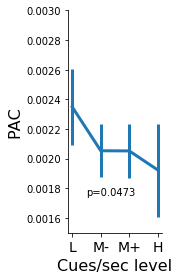

In [547]:
mmcs = log_pac.groupby(['cuesec_w']).median()[var_of_interst]
sscs = log_pac.groupby(['cuesec_w']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(2.5)


# ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )

# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel('PAC', fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)

# plt.ylim(8,12)
plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )

# ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
# ax.set_yscale("log")



print( 'Pearson: ',  stats.pearsonr(log_pac.cuesec, log_pac[var_of_interst] ))

cw_lm=ols('cuesec_w ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

ym = sum(plt.ylim())/2.4
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 0.5, ym, pval_str )


plt.ylim(0.0015,0.003)

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')
plt.tight_layout()
# plt.savefig('../Figures/pac_cuesec.pdf')

Pearson:  (-0.04410191638870546, 0.20990225078358973)
               sum_sq     df         F    PR(>F)
kb          18.049921    1.0  1.574606  0.209902
Residual  9262.214939  808.0       NaN       NaN


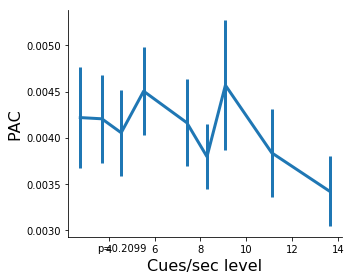

In [539]:
mmcs = log_pac.groupby(['cuesec']).mean()[var_of_interst]
sscs = log_pac.groupby(['cuesec']).sem()[var_of_interst]


fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(5)


ax.errorbar( uni, mmcs, yerr=sscs, linewidth=3 )
# ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3 )

# sns.violinplot(data=log_wel_all.groupby(['cuesec']),  palette="Set3", bw=1.2, cut=2, linewidth=1 )


fig.patch.set_facecolor('xkcd:white')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)

plt.ylabel('PAC', fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)

# plt.ylim(8,12)
# plt.xticks(  range(mmcs.size), ['L','M-','M+','H'], fontsize=14 )

# ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
# ax.set_yscale("log")



print( 'Pearson: ',  stats.pearsonr(log_pac.cuesec, log_pac[var_of_interst] ))

cw_lm=ols('cuesec ~ ' + var_of_interst , data=log_pac).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

ym = sum(plt.ylim())/3
pval_str =   'p=' + str(np.round(sm.stats.anova_lm(cw_lm, typ=2)['PR(>F)']['kb'],4))
plt.text( 3.5, ym, pval_str )

# plt.savefig('../Figures/theta_dominant_freq_cues_per_sec.pdf')
plt.tight_layout()
# plt.savefig('../Figures/pac_cuesec.pdf')

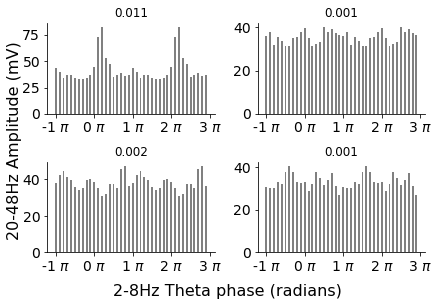

In [440]:
sub = 4
cc = 0

tmp_amp = amp_phase[sub]['amp'][cc]
tmp_phase = amp_phase[sub]['phase'][cc]

idx_trials = trials_markers[sessions[sub]]



fig = plt.figure()
# ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(6)



for trial in range(4):
    

    tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
    tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]

    bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp,bins=20)
    kb = calculate_KB(bs)
    
    
    
    ax = plt.subplot(2,2,trial+1)
    plt.bar(  bs[1][:-1]/np.pi , bs[0] , width=0.05, color='grey' )
    plt.bar(  (bs[1][:-1] + np.pi*2)/np.pi , bs[0] , width=0.05, color='grey' )
    ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(np.round(kb,3))
    plt.sca(ax)
#     plt.ylabel('Amplitude (mV)', fontsize=14)
#     plt.xlabel('Phase (radians)', fontsize=14)
    
    
    
fig.text(0.5, -0.04, '2-8Hz Theta phase (radians)', ha='center', fontsize=16)
fig.text(-0.01, 0.5, '20-48Hz Amplitude (mV)', va='center', rotation='vertical', fontsize=16)


fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()


# plt.savefig('../Figures/pac_examples.pdf', bbox_inches='tight')